In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction
For instructions on using Jupyter notebooks, see the [README.md](../../README.md) file. 

This notebook demonstrates how to work with SMAP-Sentinel data via OpenDAP from NSIDC. Specifically, we will:
* Look at the global coverage of SMAP-Sentinel for all available dates
* Identify spatially and temporally overlapping regions

# How to work with SMAP-Sentinel data using PODPAC
* Make sure you have PODPAC properly installed WITH the **datatype** optional dependencies: `pip install podpac[datatype]`

# SMAP-Sentinel background
* This product combines data from the SMAP and Sentinel programs
* To produce data, SMAP and Sentinel-1 or Sentinel-2 need to overlap
    * This makes it challenging to know what the spatial and temporal coverage of the data is
* Result is a 1km soil moisture product

# Setup: Import dependencies

In [2]:
from collections import OrderedDict
import podpac
from podpac.datalib import smap

## Provide Earth Data Login Credentials
If you do not have an earth data login, or have not activated OpenDAP access, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html).

In [3]:
import getpass
username = password = None
username = input("Username:");   password = getpass.getpass('Password:')

Username: mpuecker
Password: ··················


# Create the PODPAC SMAP Node, selecting the Sentinel product

In [4]:
# Create the SMAP node
product = 'SPL2SMAP_S'   # Level 2 SMAP-Sentinel Data
sm = smap.SMAP(product=product, username=username, password=password)

# Build PODPAC `Coordinates` of available files
PODPAC:
* Looks at the filenames within user-specified bounds for SMAP-Sentinel data
* Creates PODPAC `Coordinates` based on the filenames
* Caches the result for faster access

In [5]:
# Specify the temporal bounds of when to look for coverage and overlaps
bounds = podpac.Coordinates([['2018-11-13', '2018-11-18']], ['time'])

# Look for datafiles within these bounds (takes ~5 minutes)
# !!! Note: If `bounds` is None, this next line will take a very long while (hours) first time it is run.
# !!!       This is because it looks at the whole dataset (> 250K files), but the results will be cached.
coords_sf, srcs = sm.get_filename_coordinates_sources(bounds)
coords_sf

Coordinates
	time_lat_lon[time]: ArrayCoordinates1d(time): Bounds[2018-11-12T00:38:24, 2018-11-19T20:10:40], N[5241], ctype['midpoint']
	time_lat_lon[lat]: ArrayCoordinates1d(lat): Bounds[-54.0, 61.0], N[5241], ctype['midpoint']
	time_lat_lon[lon]: ArrayCoordinates1d(lon): Bounds[-177.0, 177.0], N[5241], ctype['midpoint']

# Compute coverage and overlaps using PODPAC `Coordinates`
* Look at 1x1 degree regions and count the number of SMAP-Sentinel data files
* For each 1x1 degree region, record pairs of data files also overlap in time 

In [6]:
world_hist = np.zeros((180, 360))
time_pair = -np.ones((180, 360), int)
time_pair_delta = np.zeros((180, 360), 'datetime64[h]')
time_pair_inds = OrderedDict()
time_pair_srcs = OrderedDict()

TOL = np.timedelta64(1, 'D')

In [7]:
time_pair_delta[:] = coords_sf['time'].coords[0]
# Loop through every coordinate (that describes a single data tile)
for k in range(coords_sf.shape[0]):
    # Extract the indexes based on the lat-lon coordinates
    lat = int((90 - (coords_sf['lat'].coords[k])))
    lon = int((180 + (coords_sf['lon'].coords[k])))
    
    # Count this tile
    world_hist[lat, lon] += 1
    
    # Record the time for the tile
    time = coords_sf['time'].coords[k]
 
    # Check if another tile has visited this region
    if time_pair[lat, lon] != -1: 
        # Another tile has visited this region. Was it recent enough to constitute an overlap? 
        if (time - time_pair_delta[lat, lon]) < TOL:
            # Yes, recent enough to constitute an overlap, record this pair
            time_pair_inds[time] = (time_pair[lat, lon], k)
            time_pair_srcs[time] = (srcs[time_pair[lat, lon]], srcs[k])

    # record this tile and its visit time
    time_pair[lat, lon] = k
    time_pair_delta[lat, lon] = time

# Set regions with no visits to nan
world_hist[world_hist == 0] = np.nan

# Look at global SMAP-Sentinel data coverage
* Europe has best spatial/temporal coverage
* Portions of the globe have no coverage

(-0.5, 359.5, 179.5, -0.5)

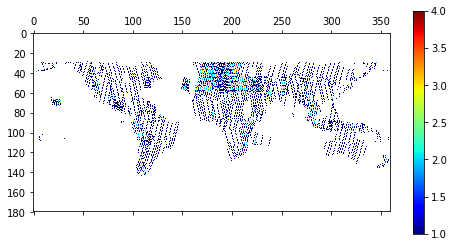

In [8]:
ax = matshow(world_hist, cmap='jet'); colorbar(); axis('scaled')

# Look at spatially/temporally overlapping data files
* Since there are two Sentinel satellites, can get two crossings within a day
* Differences can be due to:
    * Time effects from different Sentinel collection times
    * Differences in Sentinel sensors
    * Errors?

In [9]:
# Get the last pair of overlapping tiles found and plot the results
srcs = time_pair_srcs[list(time_pair_srcs)[0]]
# Set caching properties for the sources
srcs

(SMAPSource DataSource
 	source: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL2SMAP_S.002/2018.11.12/SMAP_L2_SM_SP_1AIWDV_20181112T022503_20181113T021256_057E33N_R16020_001.h5
 	interpolation: {'method': 'nearest', 'time_tolerance': numpy.timedelta64(1)},
 SMAPSource DataSource
 	source: https://n5eil02u.ecs.nsidc.org/opendap/SMAP/SPL2SMAP_S.002/2018.11.12/SMAP_L2_SM_SP_1AIWDV_20181112T022503_20181112T141033_057E33N_R16020_001.h5
 	interpolation: {'method': 'nearest', 'time_tolerance': numpy.timedelta64(1)})

## Examine the differences
* There are significant differences in the overlapping data

In [10]:
# Evaluate the first tile
o0 = srcs[0].eval(srcs[0].native_coordinates)

# Use the lat-lon coordinates of the first tile (i.e. drop the time coordinate)
coords_lat_lon = srcs[0].native_coordinates.drop('time')
# Use the time coordinates of the second tile (it might be different to within a day)
coords_time = srcs[1].native_coordinates.drop(['lat', 'lon'])
# Merge the coordinates
coords = podpac.core.coordinates.merge_dims([coords_time, coords_lat_lon])
# Evaluate the second tile
o1 = srcs[1].eval(coords)

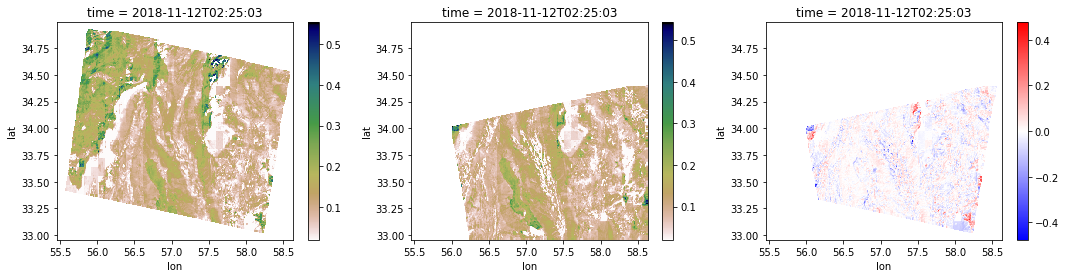

In [11]:
figure(figsize=(18, 4))
ax = subplot(131);                   o0.plot(cmap='gist_earth_r');  
subplot(132, sharex=ax, sharey=ax);  o1.plot(cmap='gist_earth_r');  
subplot(133, sharex=ax, sharey=ax); (o0-o1).plot(cmap='bwr');       